# EAS 4610
## Final Group Project
## Glacial Cycles (Pollard 1982)

### Dennis Frank
### Marcus Morris
### Nathan Warner

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import spdiags
import pandas as pd

# Introduction

# Equations

In [75]:
#Constants
a=0.81e-3 #Snowfall Constant, Unit:(1/yr) 
b=0.3e-6 #Ice Melt Constant, Unit:(1/(m*yr))
k=25 #Insolation Sensitivity
S=0 #Elevation of Current Sea Level
pi=917 #ice density (kg/m^3)
pw=1027 #sea water density (kg/m^3)
A = 5.77e-4 # 1/(m^3 yr)
alpha = 5
beta = 2
r = 0.3
nu = 100 # km^2/yr
nu = nu * 1000 * 1000

t_f = 100000
x_f = 4884000
dt = 0.01 #yr
dx = 55500 #m
nt = int(t_f/dt) + 1
nx = int(x_f/dx) + 1
x = np.linspace(0, x_f, nx)
t = np.linspace(0, t_f, nt)

c_nu = (nu * dt) / (dx**2)
c_A = (A * dt) / (4*dx**2)

In [76]:
#Function for Calculating the Mass Balance, G: (Snowfall - Ice Melt)
def G(h,h_prime,h_prev,h_prime_prev,E0,dQ): #h:ice height, h':bedrock elevation, x:distance, E0:current equilibrium altitude, dq:insolation change @ 65°N
#    E = E0 + k*dQ
#    H = h+h_prime #Surface Elevation: H=h+h'
#    if (pi*h_prev < (pw*(S-h_prime_prev))) and (h_prime < S): #Calving Conditional Statement (maybe put this in separte fxn)
#        return -20
    
#    if (H-E) <= 1500:
#        return a*(H-E) - b*(H-E)**2
    
#    else:
        return 0.56

In [86]:
#### h = np.zeros([nx, nt])
h_prime = np.zeros([nx, nt])

## Initial conditions
h_0 = np.zeros([nx])
h_prime_0 = np.zeros([nx])
h_naught = np.zeros([nx])

h[:, 0] = h_0
h_prime[:, 0] = h_prime_0

## EQUATION 3 MATRICES
h_prime_data = np.array([c_nu*np.ones(nx), (1-2*c_nu)*np.ones(nx), c_nu*np.ones(nx)])
h_prime_diags = np.array([-1, 0, 1])
h_prime_M_3 = spdiags(h_prime_data, h_prime_diags, nx, nx).toarray()

h_0_data = np.array([-c_nu*np.ones(nx), (2*c_nu)*np.ones(nx), -c_nu*np.ones(nx)])
h_0_diags = np.array([-1, 0, 1])
h_0_M_3 = spdiags(h_0_data, h_0_diags, nx, nx).toarray()

h_data = np.array([r*c_nu*np.ones(nx), (-2*r*c_nu)*np.ones(nx), r*c_nu*np.ones(nx)])
h_diags = np.array([-1, 0, 1])
h_M_3 = spdiags(h_data, h_diags, nx, nx).toarray()

## EQUATION 3 BOUNDARY CONDITIONS
h_prime_M_3[0, 0] = 0
h_prime_M_3[0, 1] = 0
h_prime_M_3[-1, -1] = 0
h_prime_M_3[-1, -2] = 0

h_0_M_3[0, 0] = 1
h_0_M_3[0, 1] = 0
h_0_M_3[-1, -1] = 1
h_0_M_3[-1, -2] = 0

h_M_3[0, 0] = 0
h_M_3[0, 1] = 0
h_M_3[-1, -1] = 0
h_M_3[-1, -2] = 0

#Define Insolation as a Function of Time (Q)
df = pd.read_csv('Milankovitch.dat',skiprows=1300,delim_whitespace=True, names=['year','lat','Q','x','y','z','v']) #only first 3 rows are of interest
Q = df['Q'].to_numpy() #values in W/m^2
n = np.ceil(len(t)/len(Q))
Q = list(np.repeat(Q,n)) #repeat values
#Run Loop to calculate dQ
Q_present=Q[-1]
dQ = np.ones((len(Q),1))
for i in np.arange(len(Q)):
    dQ[i] = Q[i] - Q_present
dQ = dQ.reshape(-1)
#Define Equilibrium-Line Altitude as a Function of latitude
E0 = (0.9e-3)*x + 55.5*2

## MASTER LOOP
for k in np.arange(0, 3000-1):
    # EQUATION 1 MATRICES
    K = np.zeros([nx])
    K[1:-1] = h[1:-1,k]**alpha + abs(((h[2:nx,k] - h[0:nx-2,k])/(2*dx)) + ((h_prime[2:nx,k] - h_prime[0:nx-2,k])/(2*dx)))**beta
    K[0] = K[1]
    K[-1] = K[nx - 2]
#    print(K)

    h_1 = np.zeros(nx)
    h_1[0:nx-2] = c_A*K[0:nx-2] + 4*c_A*K[1:nx-1] - c_A*K[2:nx]
    h_2 = np.zeros(nx)
    h_2[1:nx-1] = 1 - 8*c_A*K[1:nx-1]
    h_2[0] = 1
    h_2[-1] = 1
    h_3 = np.zeros(nx)
    h_3[2:nx] = -c_A*K[0:nx-2] + 4*c_A*K[1:nx-1] + c_A*K[2:nx]
    h_diags = np.array([-1, 0, 1])
    h_M = spdiags(np.array([h_1, h_2, h_3]), h_diags, nx, nx).toarray()

    h_p_1 = np.zeros(nx)
    h_p_1[0:nx-2] = c_A*K[0:nx-2] + 4*c_A*K[1:nx-1] - c_A*K[2:nx]
    h_p_2 = np.zeros(nx)
    h_p_2[1:nx-1] = -8*c_A*K[1:nx-1]
    h_p_3 = np.zeros(nx)
    h_p_3[2:nx] = -c_A*K[0:nx-2] + 4*c_A*K[1:nx-1] + c_A*K[2:nx]
    h_p_diags = np.array([-1, 0, 1])
    h_p_M = spdiags(np.array([h_p_1, h_p_2, h_p_3]), h_diags, nx, nx).toarray()
    
    # Find G
    G_M = np.zeros(nx)
    this_dQ = dQ[k]
    G_M[0] = G(h[0, k], h_prime[0, k], h[0, k], h_prime[0, k], E0[0], this_dQ)
    
    for i in np.arange(1, nx-1):
        G_M[i] = G(h[i, k], h_prime[i, k], h[i-1, k], h_prime[i-1, k], E0[i], this_dQ)
        
    # Find h at next time step
    h_new = h_M@h[:,k] + h_p_M@h_prime[:,k] + G_M
    h[:, k+1] = h_new.transpose()
    
    # Find h_prime at next time step    
    h_prime_new = h_prime_M_3@h_prime[:,k] + h_0_M_3@h_naught[:] + h_M_3@h[:,k]
    h_prime[:, k+1] = h_prime_new.transpose()
    
h[:,3000]

<ipython-input-86-2727d3c3aaeb>:59: RuntimeWarning: overflow encountered in power
  K[1:-1] = h[1:-1,k]**alpha + abs(((h[2:nx,k] - h[0:nx-2,k])/(2*dx)) + ((h_prime[2:nx,k] - h_prime[0:nx-2,k])/(2*dx)))**beta
<ipython-input-86-2727d3c3aaeb>:59: RuntimeWarning: overflow encountered in square
  K[1:-1] = h[1:-1,k]**alpha + abs(((h[2:nx,k] - h[0:nx-2,k])/(2*dx)) + ((h_prime[2:nx,k] - h_prime[0:nx-2,k])/(2*dx)))**beta
<ipython-input-86-2727d3c3aaeb>:59: RuntimeWarning: invalid value encountered in add
  K[1:-1] = h[1:-1,k]**alpha + abs(((h[2:nx,k] - h[0:nx-2,k])/(2*dx)) + ((h_prime[2:nx,k] - h_prime[0:nx-2,k])/(2*dx)))**beta
<ipython-input-86-2727d3c3aaeb>:65: RuntimeWarning: invalid value encountered in subtract
  h_1[0:nx-2] = c_A*K[0:nx-2] + 4*c_A*K[1:nx-1] - c_A*K[2:nx]
<ipython-input-86-2727d3c3aaeb>:71: RuntimeWarning: invalid value encountered in add
  h_3[2:nx] = -c_A*K[0:nx-2] + 4*c_A*K[1:nx-1] + c_A*K[2:nx]
<ipython-input-86-2727d3c3aaeb>:76: RuntimeWarning: invalid value encounte

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [99]:
h[:,1800]

array([ 1.00800000e+003,  1.57682600e+220, -1.40289774e+221,
        1.57679851e+220,  3.12014218e+214,  2.20232173e+180,
        3.82845080e+042,  6.86483926e+002,  6.96434335e+002,
        7.06239693e+002,  7.16591894e+002,  7.26595663e+002,
        7.35507722e+002,  7.43237475e+002,  7.49811107e+002,
        7.55440263e+002,  7.60189990e+002,  7.64339759e+002,
        7.67579908e+002,  7.70999730e+002,  7.72403393e+002,
        7.76414919e+002,  7.74291144e+002,  7.81215604e+002,
        7.72191415e+002,  7.84577473e+002,  7.66195268e+002,
        7.84420193e+002,  7.59514473e+002,  7.80788073e+002,
        7.55577047e+002,  7.76362186e+002,  7.54704532e+002,
        7.73165008e+002,  7.55555791e+002,  7.71586262e+002,
        7.57002930e+002,  7.71294761e+002,  7.58451430e+002,
        7.71850467e+002,  7.59670452e+002,  7.72855012e+002,
        7.60621221e+002,  7.74076299e+002,  7.61282817e+002,
        7.75334155e+002,  7.61878134e+002,  7.76479308e+002,
        7.62541022e+002,

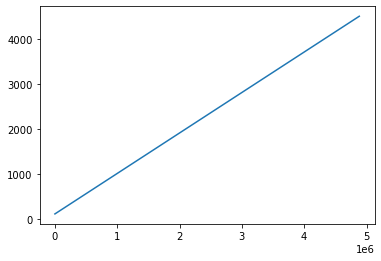

In [25]:
E0 = (0.9e-3)*x + 55.5*2
E = E0 + k*dQ[0]
plt.plot(x,E)

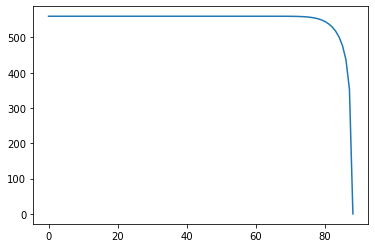

In [100]:
plt.plot(h[:,1000])
plt.show()

# Numerical Methods

# Results

# Figures

# Video Walkthrough

# References